## Building Long-Term Memory with LangMem

### Overview

This demo explains how to combine **vector database storage** with an agent framework to create **long-term memory** using **LangMem**, a library built by the LangChain team. The goal is to enable agents to remember facts across multiple interactions.

In [1]:
from langgraph.prebuilt import create_react_agent
from langgraph.store.memory import InMemoryStore
from langmem import create_manage_memory_tool, create_search_memory_tool
from langchain_core.messages import HumanMessage

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

### **Setting up LangMem**

- **LangMem** handles the memory store behind the scenes, using vector embeddings to save and retrieve information.
- Memory storage is backed by **OpenAI** embeddings in this example.

In [3]:
store = InMemoryStore(
    index={
        "dims": 1536,
        "embed": "openai:text-embedding-3-small",
    }
)

### **Creating the Workflow**

- A **ReAct agent** is created using a prebuilt LangMem utility:
    - `create_react_agent(model, tools, store)`
- No custom `StateSchema` is needed.
- Two tools are defined:
    - `manage_memory_tool`: Saves information into the store.
    - `search_memory_tool`: Retrieves information from the store.

In [4]:
agent = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[
        # Memory tools use LangGraph's BaseStore for persistence
        create_manage_memory_tool(namespace=("memories",)),
        create_search_memory_tool(namespace=("memories",)),
    ],
    store=store,
)

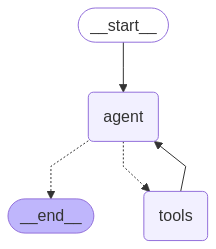

In [5]:
agent

### **Inspecting the Input Schema**

- The input schema for the agent expects a field called `messages`.
- `messages` should include:
    - SystemMessage
    - HumanMessage
    - AIMessage
    - ToolMessages (after tool calls)

In [6]:
agent.get_input_jsonschema()

{'$defs': {'BaseMessage': {'additionalProperties': True,
   'description': 'Base abstract message class.\n\nMessages are the inputs and outputs of ChatModels.',
   'properties': {'content': {'anyOf': [{'type': 'string'},
      {'items': {'anyOf': [{'type': 'string'},
         {'additionalProperties': True, 'type': 'object'}]},
       'type': 'array'}],
     'title': 'Content'},
    'additional_kwargs': {'additionalProperties': True,
     'title': 'Additional Kwargs',
     'type': 'object'},
    'response_metadata': {'additionalProperties': True,
     'title': 'Response Metadata',
     'type': 'object'},
    'type': {'title': 'Type', 'type': 'string'},
    'name': {'anyOf': [{'type': 'string'}, {'type': 'null'}],
     'default': None,
     'title': 'Name'},
    'id': {'anyOf': [{'type': 'string'}, {'type': 'null'}],
     'default': None,
     'title': 'Id'}},
   'required': ['content', 'type'],
   'title': 'BaseMessage',
   'type': 'object'}},
 'properties': {'messages': {'items': {'$re

### **Example Interaction: Setting and Retrieving Preferences**

#### a. **Initial Question**

- User asks:
    - *"What are my lighting preferences?"*
- The agent:
    - Calls the `search_memory` tool.
    - Tool responds: No memory found.
    - Agent replies: *"I don't have any information about your lighting preferences."*

In [7]:
# Ask a random question to the agent
output = agent.invoke(
    input = {
        "messages": [
            {
                "role": "user", 
                "content": "What are my lighting preferences?"
            }
        ]
    },
    config = {"configurable": {"thread_id": "1"}}
)

output['messages']

[HumanMessage(content='What are my lighting preferences?', additional_kwargs={}, response_metadata={}, id='6a668f7b-c9b2-4ad0-8da6-061dbbec831c'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Kfi09XzgC8x9AywiLvCAbE61', 'function': {'arguments': '{"query":"lighting preferences"}', 'name': 'search_memory'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 244, 'total_tokens': 260, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a', 'id': 'chatcmpl-BUdPD6uXTjdotie3rpNr2G1g9JIfW', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a58bdd83-9c97-4e46-91df-da46816c881c-0', tool_calls=[{'name': 'search_memory', 'args': {'query': 'lighting

#### **Saving New Information**

- User follows up:
    - *"Remember that I prefer dark mode."*
- The agent:
    - Calls the `manage_memory` tool.
    - Saves the new preference into the store.
    - Replies: *"I've noted that you prefer dark mode."*

In [8]:
messages = output['messages']

In [9]:
messages.append(HumanMessage("Ok. Remember that I prefer dark mode."))

In [10]:
# Store a new memory in one Session
output = agent.invoke(
    input = {
        "messages": messages,
    },
    config = {"configurable": {"thread_id": "1"}}
)

output['messages']

[HumanMessage(content='What are my lighting preferences?', additional_kwargs={}, response_metadata={}, id='6a668f7b-c9b2-4ad0-8da6-061dbbec831c'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Kfi09XzgC8x9AywiLvCAbE61', 'function': {'arguments': '{"query":"lighting preferences"}', 'name': 'search_memory'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 244, 'total_tokens': 260, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a', 'id': 'chatcmpl-BUdPD6uXTjdotie3rpNr2G1g9JIfW', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a58bdd83-9c97-4e46-91df-da46816c881c-0', tool_calls=[{'name': 'search_memory', 'args': {'query': 'lighting

#### c. **New Session Retrieval**

- A **new thread** is started with a fresh message:
    - *"What are my lighting preferences?"*
- Only this question is provided (no prior conversation).
- The agent:
    - Calls the `search_memory` tool.
    - Finds the saved memory from the previous interaction.
    - Replies correctly: *"You prefer dark mode."*

In [ ]:
# Retrieve the stored memory in another Session
output = agent.invoke(
    {
        "messages": [
            {
                "role": "user", 
                "content": "What are my lighting preferences?"
            }
        ]
    },
    config = {"configurable": {"thread_id": "2"}}
)

output['messages']

[HumanMessage(content='What are my lighting preferences?', additional_kwargs={}, response_metadata={}, id='1aecca73-97b1-4c98-89c7-0403f78b5967'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_saqS3VV3GMFnjY2sRqfyM8Hg', 'function': {'arguments': '{"query":"lighting preferences"}', 'name': 'search_memory'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 244, 'total_tokens': 260, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a', 'id': 'chatcmpl-BUdQ7svfW8xGiqrW0c9UappEWvMmn', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ddbab82c-da6e-43db-8549-f0c5a20086d5-0', tool_calls=[{'name': 'search_memory', 'args': {'query': 'lighting

### **Conclusion**

- LangMem makes it easy to extend ReAct agents with **long-term memory**.
- Agents can now recall user preferences or facts across completely different conversations.
- This memory-enhanced design is a key step toward building more **lifelike, persistent AI agents**.

- **Persistent memory** across different sessions and thread IDs.
- **Memory search and management** handled with tools abstracted from the agent's reasoning.
- **Vector-based retrieval** ensures memory is stored in a scalable, semantically searchable format.
- The user does not need to manually maintain history; it's offloaded to LangMem.